# Scanorama experiment

In [2]:
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scanorama

In [3]:
# source 3_utils.py
from utils import plot_iroot, comp_kde, kdeplot, kdeplot2, get_kde_eval, norm

## Load data

In [29]:
# d1 = ad.read_h5ad("data/dataseta0_processed.h5ad")
# d2 = ad.read_h5ad("data/datasetb0_processed.h5ad")
d1 = ad.read_h5ad("data/dynchro1_slingshot_processed.h5ad")
d2 = ad.read_h5ad("data/dynchro2_slingshot_processed.h5ad")
d2.obs["milestones"] = d2.obs.milestones.cat.rename_categories({'sC': 'sC_batch'})

In [30]:
d1.X = d1.layers["X"]
d2.X = d2.layers["X"]

## Scanorama

In [31]:
d1.X = d1.X.todense()
d2.X = d2.X.todense()

adatas_cor = scanorama.correct_scanpy(
    [d1, d2],
    return_dimred = True,
)

adata_scanorama = sc.concat(
    {"control": adatas_cor[0], "premature stop": adatas_cor[1]},
    label="batch",
    uns_merge="unique",
    index_unique="-",
)

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/anndata/_core/storage.py:39: ImplicitModificationWarning: X should not be a np.matrix, use np.ndarray instead.
  warnings.warn(msg, ImplicitModificationWarning)


Found 531 genes among all datasets
[[0.         0.98175182]
 [0.         0.        ]]
Processing datasets (0, 1)


In [32]:
xvals = np.concat((adatas_cor[0].obsm["X_scanorama"][:, 0] ,adatas_cor[1].obsm["X_scanorama"][:, 0]))
yvals = np.concat((adatas_cor[0].obsm["X_scanorama"][:, 1] ,adatas_cor[1].obsm["X_scanorama"][:, 1]))
cats = np.concat((adatas_cor[0].obs["milestones"].values ,adatas_cor[1].obs["milestones"].values))

# create a DataFrame for the legend
legend_df = pd.DataFrame({
    "x": xvals,
    "y": yvals,
    "label": cats,
})

with plt.rc_context({"figure.figsize": (4, 4)}):
    sns.scatterplot(
        data=legend_df,
        x="x",
        y="y",
        hue="label",
        legend=True,
    )


In [33]:
adata_scanorama.obsm["pca"] = adata_scanorama.obsm["X_scanorama"]
# del adata_scanorama.obsm["X_pca"]
adata_scanorama.obsm["scanorama"] = adata_scanorama.obsm["pca"]

In [34]:
# del adata_scanorama.obsm["X_scanorama"]

In [35]:
adata_scanorama.obsm["umap"] = adata_scanorama.obsm["X_umap"]
del adata_scanorama.obsm["X_umap"]

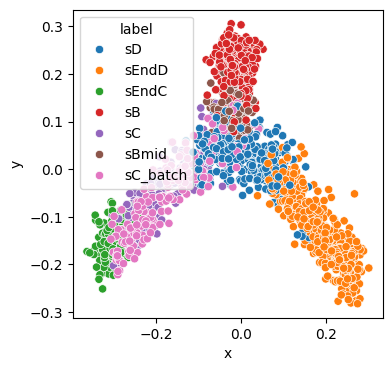

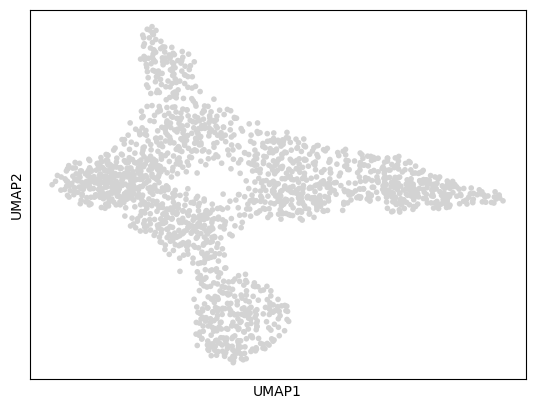

In [36]:
sc.pl.umap(adata_scanorama)

In [37]:
adata_scanorama.obsm

AxisArrays with keys: X_diffmap, X_pca, dimred, X_scanorama, pca, scanorama, umap

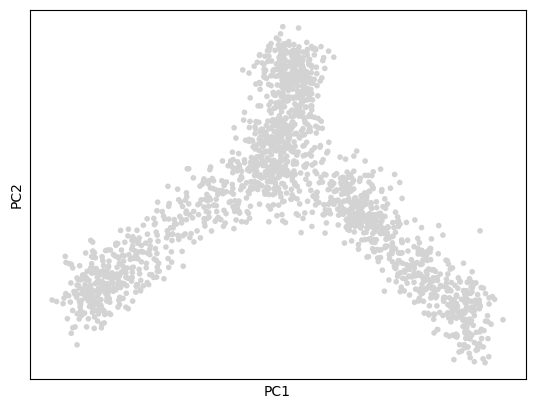

In [38]:
sc.pl.pca(adata_scanorama)

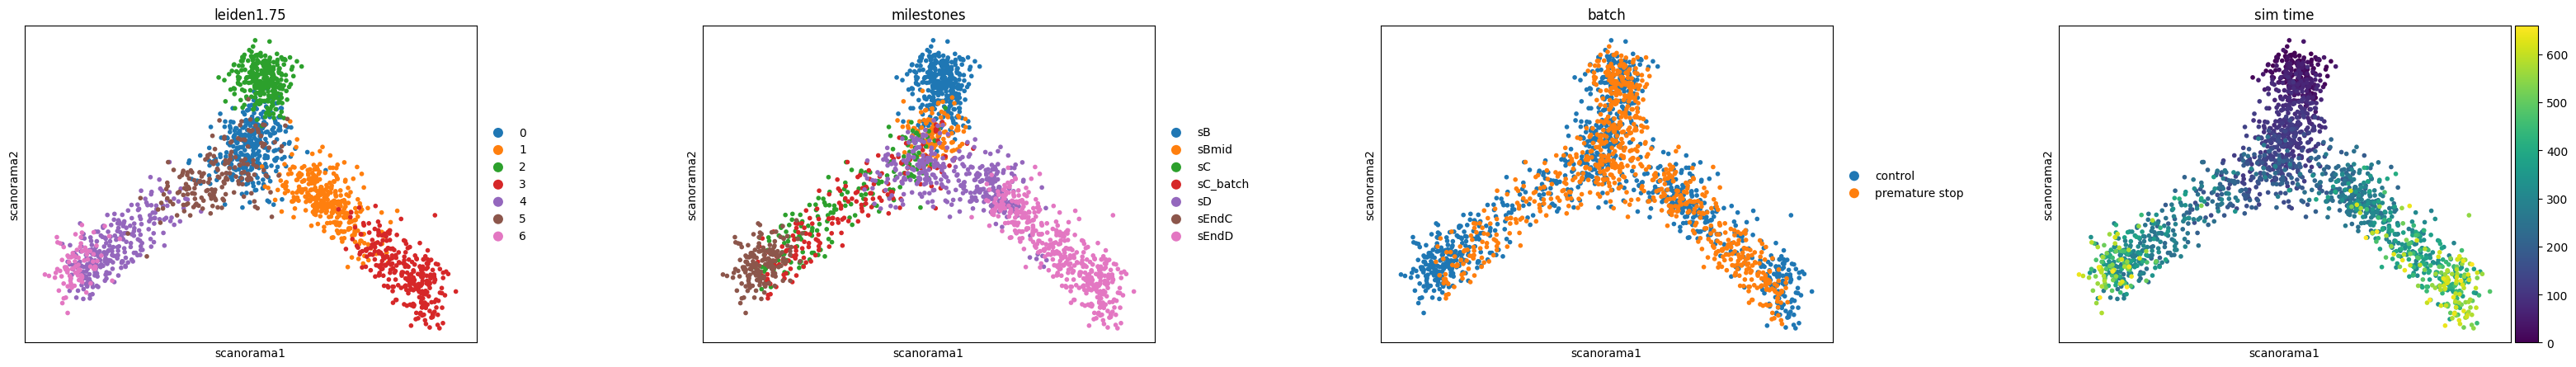

In [39]:
del adata_scanorama.obsm["X_diffmap"]
sc.pp.neighbors(adata_scanorama, use_rep="X_scanorama")
sc.tl.leiden(adata_scanorama, resolution=1.75, key_added="leiden1.75")
sc.pl.scatter(adata_scanorama, basis="scanorama", color=['leiden1.75', 'milestones', 'batch', 'sim_time'])

In [40]:
adata_scanorama.write_h5ad("data/scanorama.h5ad")

Run slingshot in R

## Pseudotime

In [50]:
adata_scanorama_result = ad.read_h5ad("data/scanorama_slingshot.h5ad")

In [51]:
adata_scanorama_result

AnnData object with n_obs × n_vars = 1822 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'leiden1.75', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: 'batch_colors', 'leiden', 'leiden1.75', 'leiden1.75_colors', 'milestones_colors', 'neighbors', 'paga', 'pca', 'traj_milestone_network', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'dimred', 'pca', 'scanorama', 'umap'
    layers: 'X'
    obsp: 'connectivities', 'distances'

/home/louise/Work/dynchro_paper/.venv/lib/python3.12/site-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in subtract
  resdat -= vmin


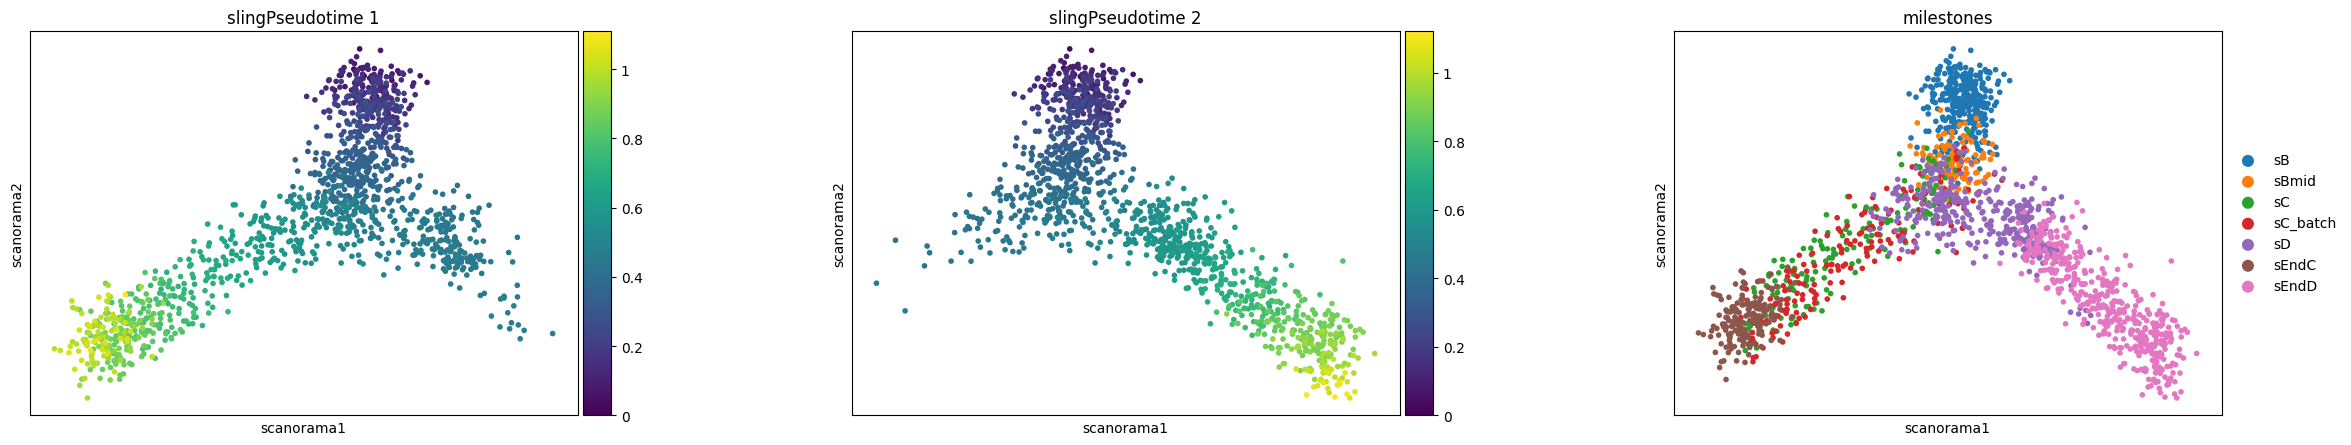

In [52]:
sc.pl.scatter(adata_scanorama_result, basis="scanorama", color=['slingPseudotime_1', 'slingPseudotime_2', "milestones"])

In [66]:
# select all cells that are not NA in slingPseudotime_1
clin = adata_scanorama_result[~adata_scanorama_result.obs.slingPseudotime_1.isna()]
dlin = adata_scanorama_result[~adata_scanorama_result.obs.slingPseudotime_2.isna()]

In [54]:
%matplotlib inline

View of AnnData object with n_obs × n_vars = 180 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'leiden1.75', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: 'batch_colors', 'leiden', 'leiden1.75', 'leiden1.75_colors', 'milestones_colors', 'neighbors', 'paga', 'pca', 'traj_milestone_network', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'dimred', 'pca', 'scanorama', 'umap'
    layers: 'X'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 180 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'leiden1.75', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: 'batch_colors', 'leiden', 'leiden1.75', 'leiden1.75_colors', 'milestones_colors', 'neighbors', 'paga', 'pca', 'traj_milestone_network', 'umap'
    obsm: 'X_pca', 'X_s

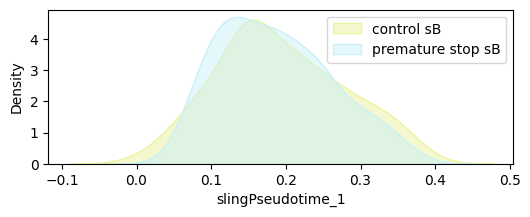

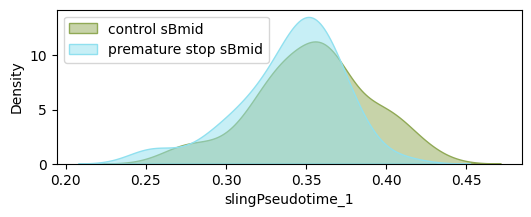

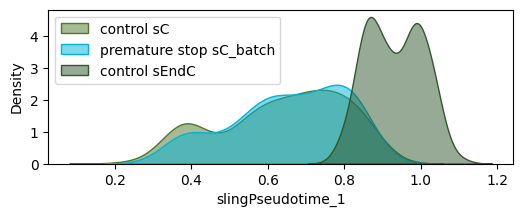

In [55]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", time_column = "slingPseudotime_1", colors = ["#ecf39e", "#caf0f8"])
    comp_kde(clin, "sBmid",time_column = "slingPseudotime_1", colors = ["#90a955", "#90e0ef"])
    
    kdeplot2(clin, "control", "sC",time = "slingPseudotime_1", milestone_column = "milestones", color="#4f772d")
    kdeplot2(clin, "premature stop", "sC_batch",time = "slingPseudotime_1", milestone_column = "milestones", color="#00b4d8")
    kdeplot2(clin, "control", "sEndC", time = "slingPseudotime_1",milestone_column = "milestones", color="#31572c")
    plt.legend()

View of AnnData object with n_obs × n_vars = 180 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'leiden1.75', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: 'batch_colors', 'leiden', 'leiden1.75', 'leiden1.75_colors', 'milestones_colors', 'neighbors', 'paga', 'pca', 'traj_milestone_network', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'dimred', 'pca', 'scanorama', 'umap'
    layers: 'X'
    obsp: 'connectivities', 'distances'
View of AnnData object with n_obs × n_vars = 180 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'leiden1.75', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: 'batch_colors', 'leiden', 'leiden1.75', 'leiden1.75_colors', 'milestones_colors', 'neighbors', 'paga', 'pca', 'traj_milestone_network', 'umap'
    obsm: 'X_pca', 'X_s

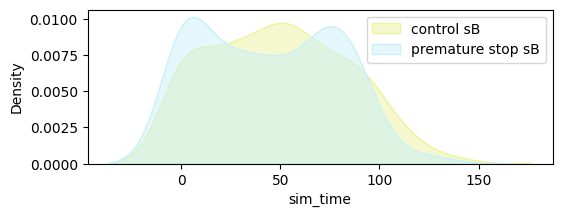

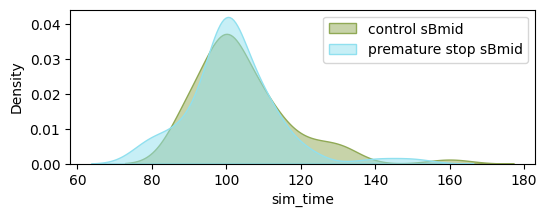

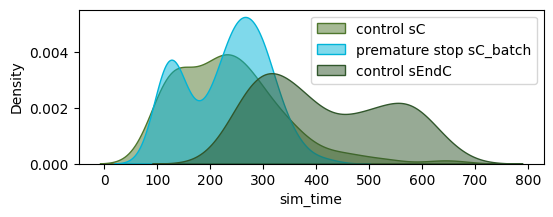

In [56]:
with plt.rc_context(rc={"figure.figsize": (6, 2)}):
    comp_kde(clin, "sB", colors = ["#ecf39e", "#caf0f8"], time_column="sim_time")
    comp_kde(clin, "sBmid", colors = ["#90a955", "#90e0ef"], time_column="sim_time")
    
    kdeplot2(clin, "control", "sC", milestone_column = "milestones", color="#4f772d", time="sim_time")
    kdeplot2(clin, "premature stop", "sC_batch", milestone_column = "milestones", color="#00b4d8", time="sim_time")
    kdeplot2(clin, "control", "sEndC", milestone_column = "milestones", color="#31572c",  time="sim_time")
    plt.legend()

# Metrics

## Between sim_time and pseudotime

In [62]:
max(clin.obs.slingPseudotime_1)

1.109084810457092

In [63]:
gtx, gty, gtkde = get_kde_eval(norm(clin.obs.sim_time), bandwith=0.1)
bcx, bcy, bckde = get_kde_eval(norm(clin.obs.slingPseudotime_1), bandwith=0.1)

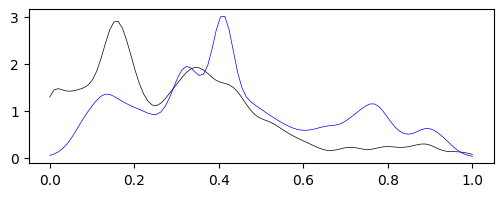

In [64]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(gtx, gty, color="black", lw=0.5)
ax.plot(bcx, bcy, color="blue", lw=0.5)

In [65]:
import scipy.stats

m = scipy.stats.wasserstein_distance(norm(clin.obs.sim_time), norm(clin.obs.slingPseudotime_1))
print(f"Wasserstein distance scanorama: {m}")

Wasserstein distance scanorama: 0.1465775911814553


## Between batches and milestones?

In [ ]:
b1 = adata_scanorama_result[adata_scanorama_result.obs.batch == "control"]
b2 = adata_scanorama_result[adata_scanorama_result.obs.batch == "premature stop"]
# select for existence of slingPseudotime_1
b1 = b1[~b1.obs.slingPseudotime_1.isna()]
b2 = b2[~b2.obs.slingPseudotime_1.isna()]

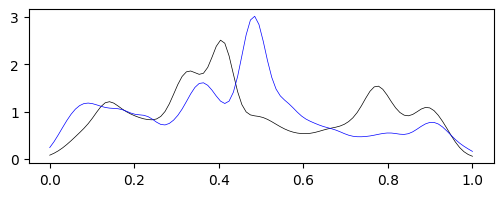

In [47]:
b1_ptx, b1_pty, b1_gkde = get_kde_eval(b1.obs.slingPseudotime_1, bandwith=0.1)
b2_ptx, b2_pty, b2_gkde = get_kde_eval(b2.obs.slingPseudotime_1, bandwith=0.1)
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(b1_ptx, b1_pty, color="black", lw=0.5)
ax.plot(b2_ptx, b2_pty, color="blue", lw=0.5)

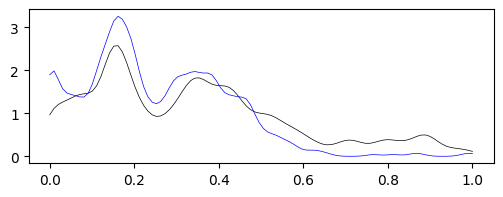

In [48]:
b1_gtx, b1_gty, b1_pkde = get_kde_eval(b1.obs.sim_time, bandwith=0.1)
b2_gtx, b2_gty, b2_pkde = get_kde_eval(b2.obs.sim_time, bandwith=0.1)
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(b1_gtx, b1_gty, color="black", lw=0.5)
ax.plot(b2_gtx, b2_gty, color="blue", lw=0.5)

In [ ]:
m = scipy.stats.wasserstein_distance(norm(b1.obs.slingPseudotime_1), norm(b2.obs.slingPseudotime_1))
print(f"Wasserstein distance control vs premature stop: {m}")

Wasserstein distance control vs premature stop: 0.050203430353550585


In [44]:
m = scipy.stats.wasserstein_distance(norm(b1.obs.sim_time), norm(b2.obs.sim_time))
print(f"Wasserstein distance control vs premature stop: {m}")

Wasserstein distance control vs premature stop: 0.08958992902842026


In [54]:
before_c1_x = np.load("data/before_c1_x.npy")
before_c1_y = np.load("data/before_c1_y.npy")
before_c2_x = np.load("data/before_c2_x.npy")
before_c2_y = np.load("data/before_c2_y.npy")
before_pseudotime = np.load("data/before_pseudotime.npy")
before_pseudotime_x = np.load("data/before_pseudotime_x.npy")   
before_pseudotime_y = np.load("data/before_pseudotime_y.npy")

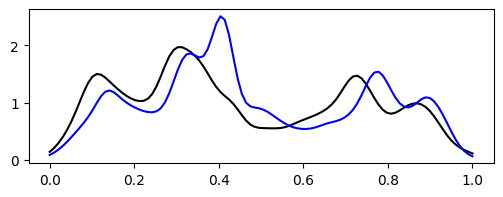

In [52]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(before_c1_x, before_c1_y, label="before c1", color="black")
ax.plot(b1_ptx, b1_pty, label="after c1", color="blue")

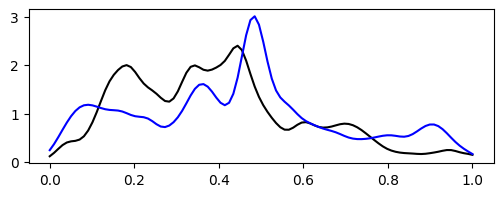

In [ ]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(before_c2_x, before_c2_y, label="before c2", color="black")
ax.plot(b2_ptx, b2_pty, label="after c2", color="blue")

In [55]:
after_pseudotime = adata_scanorama_result.obs.slingPseudotime_1.values
m = scipy.stats.wasserstein_distance(norm(before_pseudotime), norm(after_pseudotime))
print(f"Wasserstein distance before vs after c1: {m}")

Wasserstein distance before vs after c1: nan


/home/louise/Work/dynchro_paper/1_poc_2patientsbatch/utils.py:85: RuntimeWarning: invalid value encountered in subtract
  return (x - np.min(x)) / (np.max(x) - np.min(x)) * max_value


## between orig & after

In [70]:
clin_after = clin
dlin_after = dlin

# select all where linC is True
clin_before = adata_scanorama_result[adata_scanorama_result.obs.linC == "TRUE"]
dlin_before = adata_scanorama_result[adata_scanorama_result.obs.linD == "TRUE"]
# dlin_before = dlin[dlin.obs.linC == "TRUE"]

In [71]:
clin_before

View of AnnData object with n_obs × n_vars = 1186 × 531
    obs: 'step_ix', 'simulation_i', 'sim_time', 'milestones', 'leiden', 'dpt_pseudotime', 'orig_linD_pseudotime', 'orig_linC_pseudotime', 'linD', 'linC', 'batch', 'leiden1.75', 'slingPseudotime_1', 'slingPseudotime_2'
    uns: 'batch_colors', 'leiden', 'leiden1.75', 'leiden1.75_colors', 'milestones_colors', 'neighbors', 'paga', 'pca', 'traj_milestone_network', 'umap'
    obsm: 'X_pca', 'X_scanorama', 'dimred', 'pca', 'scanorama', 'umap'
    layers: 'X'
    obsp: 'connectivities', 'distances'

In [72]:
cbx, cby, cbkde = get_kde_eval(norm(clin_before.obs.orig_linC_pseudotime), bandwith=0.1)
dbx, dby, dbkde = get_kde_eval(norm(dlin_before.obs.orig_linD_pseudotime), bandwith=0.1)

cax, cay, cakde = get_kde_eval(norm(clin_after.obs.slingPseudotime_1), bandwith=0.1)
dax, day, dakde = get_kde_eval(norm(dlin_after.obs.slingPseudotime_2), bandwith=0.1)

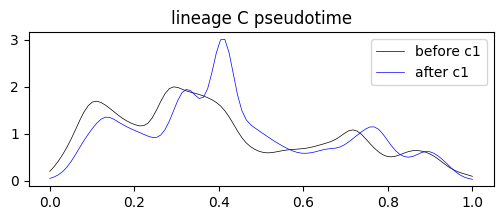

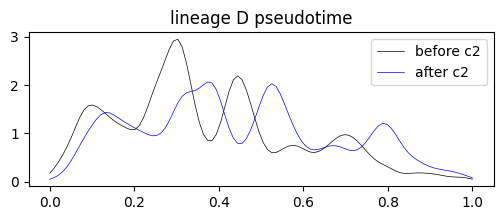

In [79]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(cbx, cby, color="black", lw=0.5, label="before c1")
ax.plot(cax, cay, color="blue", lw=0.5, label="after c1")
plt.title("lineage C pseudotime")
plt.legend()
plt.show()
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot(111)
ax.plot(dbx, dby, color="black", lw=0.5, label="before c2")
ax.plot(dax, day, color="blue", lw=0.5, label="after c2")
plt.title("lineage D pseudotime")
plt.legend()
plt.show()

In [81]:
c_wasserstein = scipy.stats.wasserstein_distance(cbx, cax, cby, cay)
print(f"Wasserstein distance before vs after C: {c_wasserstein}")
d_wasserstein = scipy.stats.wasserstein_distance(dbx, dax, dby, day)
print(f"Wasserstein distance before vs after D: {d_wasserstein}")

Wasserstein distance before vs after C: 0.03593990337986423
Wasserstein distance before vs after D: 0.07098098984259761
